In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## Importing The Required Libraries 

In [2]:
!pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install torchtext==0.18.0 --no-deps


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 3.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2

In [3]:
import torchtext
torchtext.__version__

'0.18.0+cpu'

In [4]:
import torch 
import torchtext 
from torchtext import vocab
from torchtext.vocab import GloVe
import pandas as pd
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence 

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Loading The Data

In [5]:
 data=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
data["sentiment"] = data["sentiment"].map({
    "negative": 0,
    "positive": 1
})


In [7]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [8]:
class CSVDataset(Dataset):
    def __init__(self,dataframe):
        self.df=dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        review=self.df.iloc[idx]['review']
        label=torch.tensor(self.df.iloc[idx]['sentiment'],dtype=torch.long)
        return review,label

In [9]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(data,test_size=0.2,random_state=42)
train_dataset=CSVDataset(train_df)
test_dataset=CSVDataset(test_df)

## DataLoader

In [10]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [11]:
reviews,labels=next(iter(train_dataloader))
print(reviews[0],labels[0])

(Caution: several spoilers)<br /><br />Someday, somewhere, there's going to be a post-apocalyptic movie made that doesn't stink. Unfortunately, THE POSTMAN is not that movie, though I have to give it credit for trying.<br /><br />Kevin Costner plays somebody credited only as "the Postman." He's not actually a postman, just a wanderer with a mule in the wasteland of a western America devastated by some unspecified catastrophe. He trades with isolated villages by performing Shakespeare. Suddenly a pack of bandits called the Holnists, the self-declared warlords of the West, descend upon a village that Costner's visiting, and their evil leader Gen. Bethlehem (Will Patton) drafts Costner. After much misery and numerous efforts to break Costner's spirit, he escapes, thus ending a lengthy section of the movie that could have been told better in a three-minute flashback.<br /><br />We now finally get to the major premise: the escaped Costner finds an abandoned mail truck and delivers the lette

## Getting Glove Embeddings and Indexes

In [12]:
glove=GloVe(name="6B",dim=50)

.vector_cache/glove.6B.zip: 862MB [04:06, 3.49MB/s]                               
100%|█████████▉| 399999/400000 [00:13<00:00, 30363.18it/s]


In [13]:
import torch.nn as nn
embeddings=nn.Embedding.from_pretrained(glove.vectors,freeze=True)

In [14]:
from torchtext.data.utils import get_tokenizer
import nltk
tokenizer=get_tokenizer("basic_english")

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [15]:
word_to_index=glove.stoi
index_to_word=glove.itos
vocab = torchtext.vocab.vocab(glove.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [16]:
vocab_size=len(vocab)
vocab_size

400002

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In [19]:
max_len=256
def collate_batch(batch):
    label_list=[]
    text_list=[]
    for _text,_label in  batch:
        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text)[:max_len],dtype=torch.int64))
    label_list=torch.tensor(label_list,dtype=torch.int64)
    text_list=pad_sequence(text_list,batch_first=True)
    return label_list.to(device),text_list.to(device)

In [20]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


In [21]:
label,sequence=next(iter(train_dataloader))
label,sequence

(tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 1, 0, 0]),
 tensor([[   22,    16,  5281,  ...,     0,     0,     0],
         [    2,   321,  2942,  ...,     9,  4524,     3],
         [   43,    59, 37140,  ...,     0,     0,     0],
         ...,
         [    2, 34398,    17,  ...,     0,     0,     0],
         [   61,    50,  1067,  ...,     4,    86, 27622],
         [   39,   193,  1013,  ...,     0,     0,     0]]))

## Defining Normal Architecture of the Model

In [22]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [23]:
class Net(nn.Module):
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding.from_pretrained(glove.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            max_len=256
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Net(
  (emb): Embedding(400000, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=50, out_features=2, bias=True)
)

In [25]:
imdb_label={0:"negative",1:"positive"}

In [26]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [27]:
predict("I like sports and stuff", text_pipeline, model)

'negative'

In [28]:
from tqdm.auto import tqdm
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [29]:
def save_list_to_file(lst, filename):
    with open(filename + ".txt", "w") as f:
        for item in lst:
            f.write(f"{item}\n")


In [30]:
import os
import time 
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1),desc="Epochs", total=epochs):
        model.train()
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate(test_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                print("save model epoch",epoch)
                torch.save(model.state_dict(),model_path)
                save_list_to_file(lst=acc_epoch,filename=acc_dir)
                save_list_to_file(lst=cum_loss_list,filename=loss_dir)
                
    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

In [31]:
import time 
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working"
file_name = "model_IMDB dataset small2.pth"
train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            test_dataloader=test_dataloader, 
            epochs=2, 
            save_dir=save_dir, 
            file_name=file_name
           )

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 866.1856060624123
0.5953
save model epoch 1
Epoch 2/2 - Loss: 834.6966834068298
0.6056
save model epoch 2
Training time: 355.4322772026062


In [32]:
def plot(cost,acc_epoch):
    fig,ax1=plt.subplots()
    ax1.plot(cost,color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2=ax1.twinx()
    ax2.plot(acc_epoch,color='blue')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='y', color='blue')
    fig.tight_layout()
    plt.show()

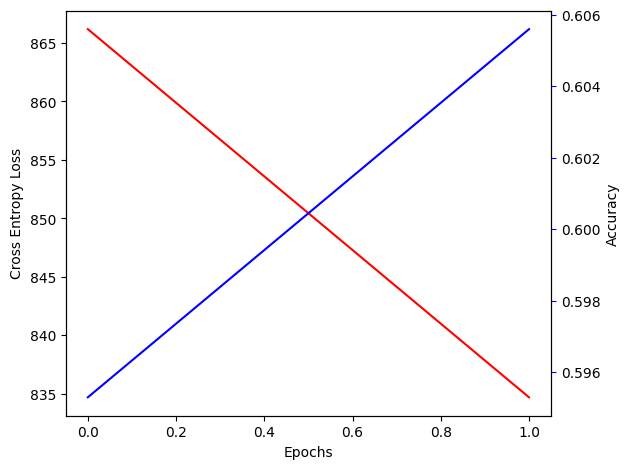

In [33]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_IMDB dataset small2_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_IMDB dataset small2_loss.txt")
plot(cum_loss_list,acc_epoch)

## Pretraining on AG News Dataset 



In [34]:
!pip install torchdata==0.7.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 3.9 MB/s eta 0:00:0000:01
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.7.1 which is incompatible.


In [35]:
ag_train=pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
ag_test=pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')

In [36]:
ag_train

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [37]:
ag_train['Class Index'].unique()

array([3, 4, 2, 1])

In [38]:
ag_map={1:"World",2:"Sports",3:"Business",4:"Science / Technology"}

In [39]:
ag_train=ag_train.drop(columns=["Title"])
ag_test=ag_test.drop(columns=["Title"])

In [40]:
ag_train

,Class Index,Description
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."
...,...,...
119995,1,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Red Sox general manager Theo Epstein acknowled...
119997,2,The Miami Dolphins will put their courtship of...
119998,2,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [41]:
class AGCSVDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,index):
        label=torch.tensor(self.dataset['Class Index'][index],dtype=torch.long)
        des=self.dataset['Description'][index]
        return des,label

In [ ]:
train_AGDataset=AGCSVDataset(ag_train)
test_AGDataset=AGCSVDataset(ag_test)

In [ ]:
BATCH_SIZE=32
train_AGDataLoader=DataLoader(train_AGDataset,shuffle=True,batch_size=BATCH_SIZE)
test_AGDataLoader=DataLoader(test_AGDataset,shuffle=True,batch_size=BATCH_SIZE)

In [ ]:
des,label=next(iter(train_AGDataLoader))
print(des[0],label[0])

AP - BellSouth Corp. said Thursday it has completed the sale of some if its Latin American assets and will use the proceeds to help pay for Cingular Wireless LLC's  #36;41 billion purchase of AT amp;T Wireless Services Inc. tensor(4)


In [ ]:
BATCH_SIZE=32
train_AGDataLoader=DataLoader(train_AGDataset,shuffle=True,batch_size=BATCH_SIZE,collate_fn=collate_batch)
test_AGDataLoader=DataLoader(test_AGDataset,shuffle=True,batch_size=BATCH_SIZE,collate_fn=collate_batch)

In [ ]:
import time 
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working"
file_name = "model_AG NEWS small1.pth"
model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

train_model(model=model_ag_news, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            test_dataloader=test_dataloader, 
            epochs=2, 
            save_dir=save_dir, 
            file_name=file_name
           )

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 800.9365845322609
0.6818
save model epoch 1
Epoch 2/2 - Loss: 757.2174324095249
0.7101
save model epoch 2
Training time: 357.3878331184387


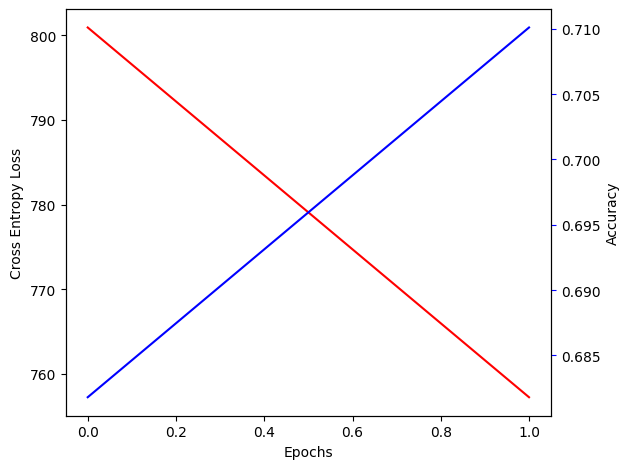

In [ ]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_AG NEWS small1_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_AG NEWS small1_loss.txt")
plot(cum_loss_list,acc_epoch)

## 